<a href="https://colab.research.google.com/github/s-sridhar24/EVA4-S5/blob/master/play_EVA4S5F4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Program Targets:

Consistent accuracy of 99.4%

Achieve using less than 10K parameters and in <= 15 epochs

Share this as 5 steps with obj, analysis for each step

# Step 4 Objectives:

Prune parameters to under 10K retaining performance

# Step 4 Results and analysis

Parameters pruned to 9938
Test Performance touched 99.51%, stayed in the 99.35+ level steadily in the last several epochs. Re run results below, it shows peak of 99.45 and several 99.38 upwards.

**Lots of learnings from this step. In the process of trying to tune, following considerations were used for each of these decisions:**

Included LR Scheduler. It did not cause a marked improvement, I did not tune this further.

Reverted batch size to 128 after trying smaller sizes.

Tried lower and higher drop rates and settled for 0.03

Experimented with fewer layers, including MaxPooling after every RF 5, tried with very few neurons in early layers and expanding at the end. And flat count and reverse counts. increase-strangle-increase patterns.
The pattern in the code now gave best results.

Wish there was a simple way to specify architecture in PyTorch. Maybe a graphical method or calling a class and passing a dataframe.

Included Image augmentation options but held it off for Step 5.

**re run of the same file gives different results. 


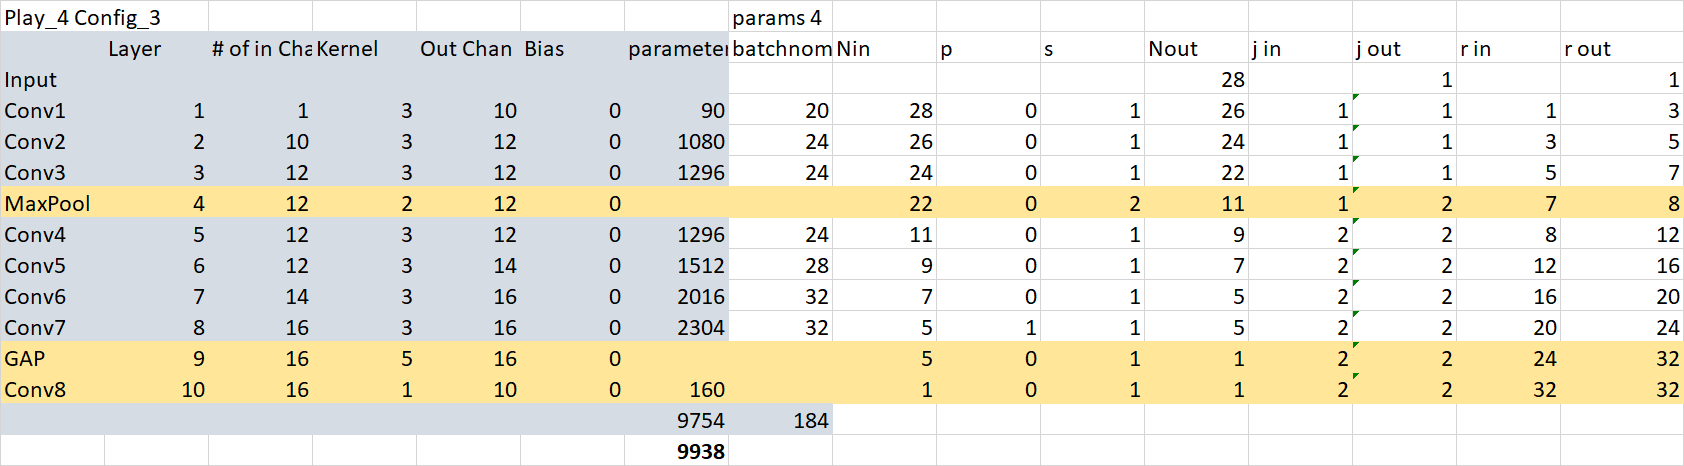

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       #transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

Same dataset so not important in this step

# The model


In [0]:
import torch.nn.functional as F
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) 
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.0049800872802734375 Batch_id=1874 Accuracy=94.82: 100%|██████████| 1875/1875 [00:35<00:00, 52.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9881/10000 (98.81%)

EPOCH: 1


Loss=0.01650412380695343 Batch_id=1874 Accuracy=98.14: 100%|██████████| 1875/1875 [00:34<00:00, 53.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9910/10000 (99.10%)

EPOCH: 2


Loss=0.03794991970062256 Batch_id=1874 Accuracy=98.48: 100%|██████████| 1875/1875 [00:34<00:00, 53.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9918/10000 (99.18%)

EPOCH: 3


Loss=0.005411982536315918 Batch_id=1874 Accuracy=98.69: 100%|██████████| 1875/1875 [00:35<00:00, 52.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.0444951206445694 Batch_id=1874 Accuracy=98.79: 100%|██████████| 1875/1875 [00:34<00:00, 54.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

EPOCH: 5


Loss=0.0022343099117279053 Batch_id=1874 Accuracy=98.90: 100%|██████████| 1875/1875 [00:35<00:00, 53.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.0006915628910064697 Batch_id=1874 Accuracy=98.98: 100%|██████████| 1875/1875 [00:35<00:00, 52.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.0017340779304504395 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:34<00:00, 60.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.007740288972854614 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [00:35<00:00, 58.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.10137608647346497 Batch_id=1874 Accuracy=99.10: 100%|██████████| 1875/1875 [00:34<00:00, 53.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.0013247132301330566 Batch_id=1874 Accuracy=99.18: 100%|██████████| 1875/1875 [00:34<00:00, 54.04it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.0038416683673858643 Batch_id=1874 Accuracy=99.15: 100%|██████████| 1875/1875 [00:35<00:00, 53.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.11218170821666718 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:34<00:00, 54.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.005568832159042358 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:34<00:00, 53.92it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.004674866795539856 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:35<00:00, 52.35it/s]



Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

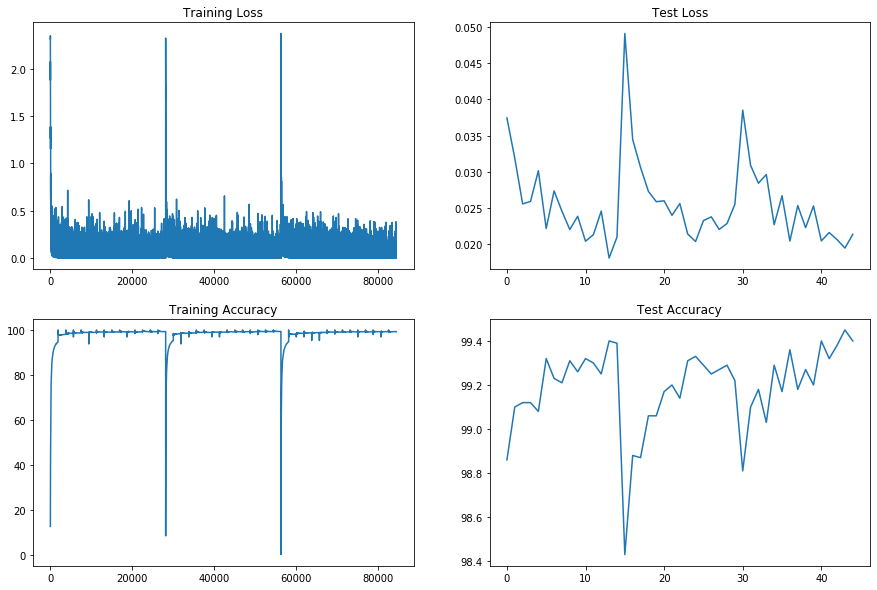

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")